In [1]:
# Importing the libraries

using CairoMakie

In [2]:
# Function for importing the data

function read_data(filename, keys)
    
    data = []
    
    for line in readlines(filename)
    
        if line == "" continue end
        if ! occursin(line[1], "1234567890") continue end
    
        line_splitted = split(line, "\t")
        n_val = Dict()
    
        for (i, key) in enumerate(keys)
            n_val[key] = parse(Float64, line_splitted[i])
        end

        push!(data, n_val)
    
    end

    return data

end

read_data (generic function with 1 method)

In [3]:
# Select only particular elements of the dict

function select(data, key)

    return [elem[key] for elem in data]
    
end

select (generic function with 1 method)

In [4]:
# filter helper function

function filter(data, critereon)

    res = []
    
    for elem in data
        if elem[critereon[1]] == critereon[2] push!(res, elem) end
    end

    return res
    
end

filter (generic function with 1 method)

In [5]:
function get_average_val(data, critereons)

    for critereon in critereons
        data = filter(data, critereon)
    end

    length = size(data, 1)

    if length == 0 return 0 end

    for i in 2:length
        for (key, val) in data[i]
            data[1][key] += val
        end
    end

    for (key, _) in data[1]
        data[1][key] /= length
    end

    return data[1]

end

get_average_val (generic function with 1 method)

In [6]:
function get_average_data(data, critereons)

    final_data = []

    keys = []
    vals = []

    for (key, val) in critereons
        push!(keys, key)
        push!(vals, val)
    end

    for config in Iterators.product(vals...)
        res = get_average_val(data, collect(zip(keys, config)))
        if res != 0 push!(final_data, res) end
    end

    return final_data

end

get_average_data (generic function with 1 method)

In [7]:
# Definining the file paths

file_path_cpu = "../time_cpu.txt"
file_path_gpu = "../time_gpu.txt"

"../time_gpu.txt"

In [8]:
# Defining the keys for the data

keys_cpu = ["nb_cores", # Number of cores running the simulation (CPU only)
            "nb_point", # Number of points in the grid (nb_point x nb_point x nb_point)
            "duration", # For how long we simulate the ocean (in mins)
            "time_MPI", # Time it took for MPI to initialize (CPU only)
            "time_gri", # Time it took for the grid to initialize (in secs)
            "time_mod", # Time it took for the model to initialize (in secs)
            "time_sim", # Time it took for the simulation to initialize (in secs)
            "dura_sim", # Time it took for the simulation to run (in secs)
            "nb_steps"] # Number of steps used (by one core) during the simulation (in secs)

keys_gpu = ["nb_point", "duration", "time_gri", "time_mod", "time_sim", "dura_sim", "nb_steps"]

7-element Vector{String}:
 "nb_point"
 "duration"
 "time_gri"
 "time_mod"
 "time_sim"
 "dura_sim"
 "nb_steps"

In [9]:
# Finally importing the data

data_cpu = get_average_data(
    read_data(file_path_cpu, keys_cpu), 
    [
        ("nb_cores", [1, 2, 4, 8, 16, 32]),
        ("nb_point", [32, 64, 128, 256]),
        ("duration", [30, 60, 90, 120])
    ]
)

data_gpu = get_average_data(
    read_data(file_path_gpu, keys_gpu), 
    [
        ("nb_point", [32, 64, 128, 256]),
        ("duration", [30, 60, 90, 120])
    ]
)

1

1

In [10]:
# Plotting the main time

function plot_data(data_cpu, data_gpu, critereon, abscices, ordonates)

    fig = Figure()
    ax = Axis(
        fig[1, 1],
        xlabel = abscices,
        ylabel = "time $ordonates (secs)",
        title = "Comparison of the performance of the different architectures \n (at $(critereon[1]) $(critereon[2]))"
    )

    filtered_gpu_data = filter(data_gpu, critereon)
    gpu_absices = select(filtered_gpu_data, abscices)
    gpu_ordonates = select(filtered_gpu_data, ordonates)
    
    scatter!(ax, gpu_absices, gpu_ordonates, marker = :cross, label = "GPU")
    lines!(ax, gpu_absices, gpu_ordonates)
    
    
    for nb_cores in [1, 2, 4, 8, 16, 32]
        filtered_cpu_data = filter(filter(data_cpu, ("nb_cores", nb_cores)), critereon)
        cpu_absices = select(filtered_cpu_data, abscices)
        cpu_ordonates = select(filtered_cpu_data, ordonates)
        
        scatter!(ax, cpu_absices, cpu_ordonates, marker = :cross, label = "CPU ($nb_cores) cores")
        lines!(ax, cpu_absices, cpu_ordonates)
    end

    axislegend(ax, position = :lt)
    
    return fig

end

plot_data (generic function with 1 method)

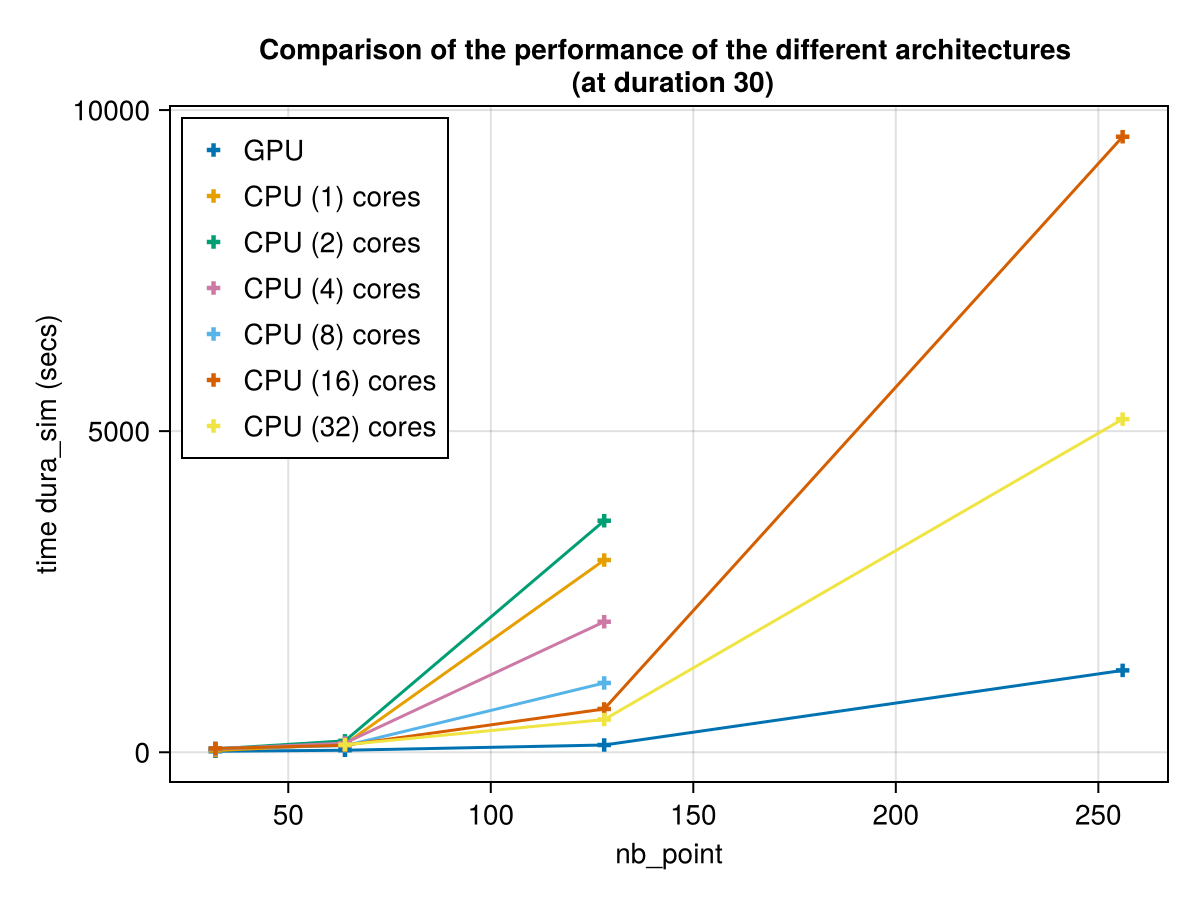

In [11]:
# Now have fun!

plot_data(data_cpu, data_gpu,
    ("duration", 30),
    "nb_point",
    "dura_sim"
)

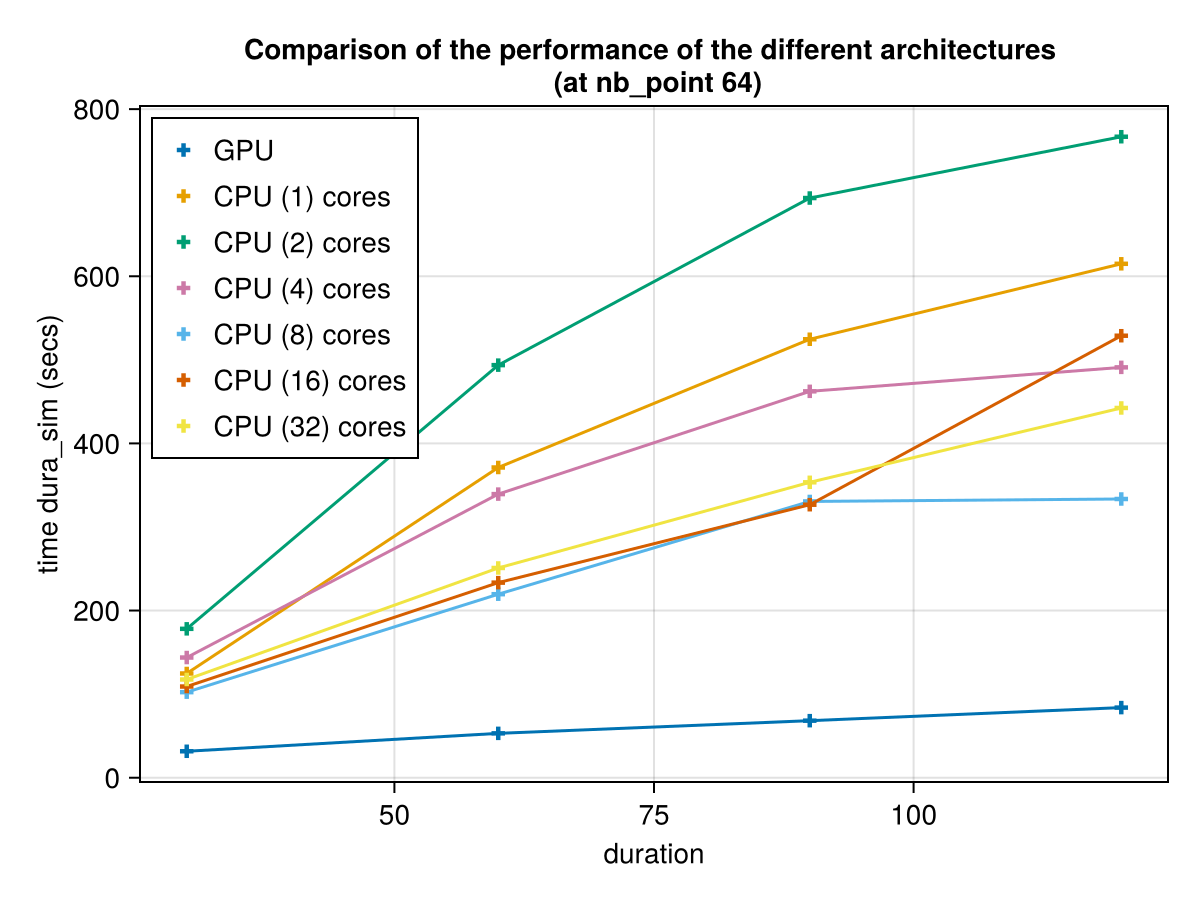

In [12]:
plot_data(data_cpu, data_gpu,
    ("nb_point", 64),
    "duration",
    "dura_sim"
)

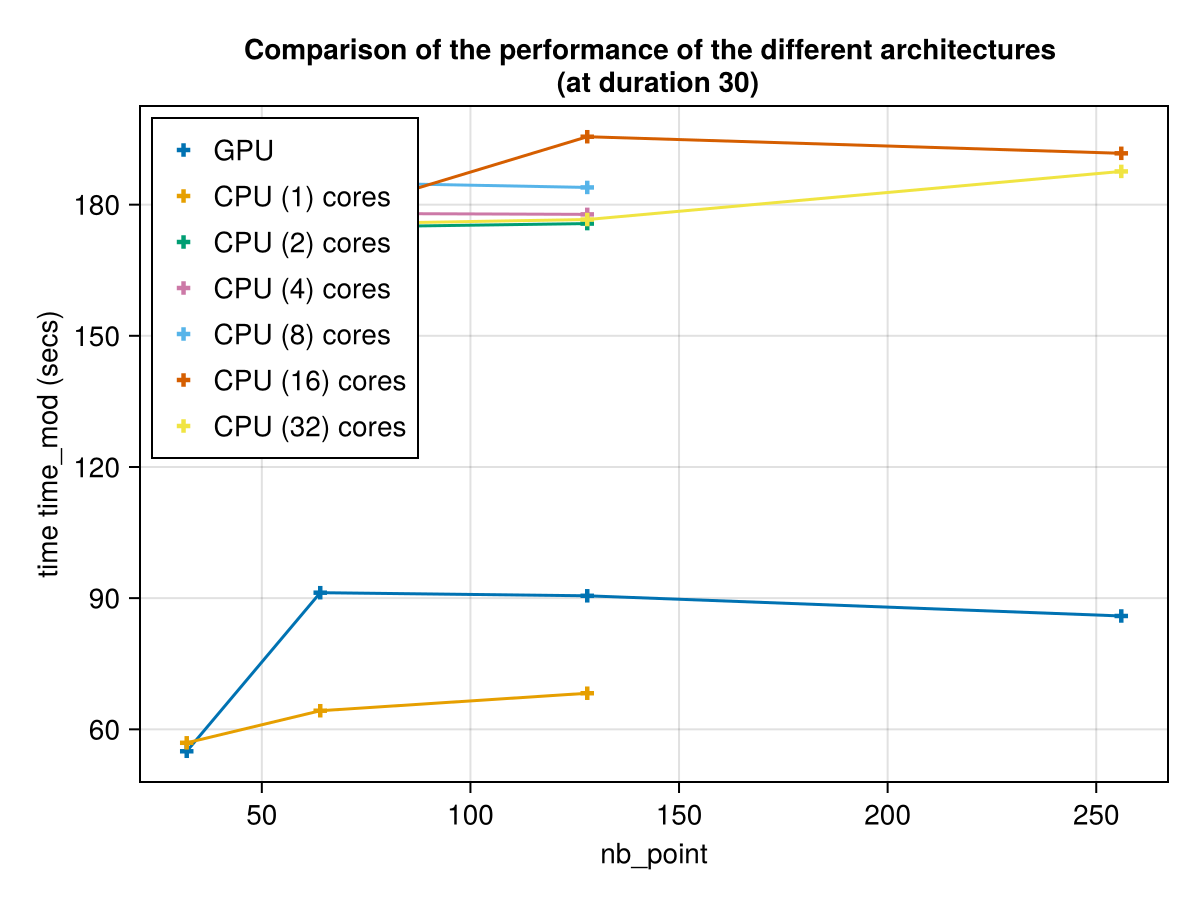

In [13]:
plot_data(data_cpu, data_gpu,
    ("duration", 30),
    "nb_point",
    "time_mod"
)